In [46]:
%matplotlib notebook
from time import time
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import offsetbox
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm

from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, random_projection)
from scipy.sparse import linalg, eye
from scipy.linalg import eigh, svd, qr, solve, lstsq
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import pairwise_distances, rbf_kernel
from sklearn.datasets import fetch_mldata
from numpy.linalg import inv
from sklearn import neighbors

random.seed(0)
N = 1000

digits = fetch_mldata('MNIST original')
X = digits.data
indices = list(range(len(X)))
random.shuffle(indices)
X = X[indices[:N],:]
X = X[0:N, :]
X = 1.0 * X

print(X.shape)
y = digits.target
y = y[indices[:N]]
n_samples, n_features = X.shape
n_neighbors = 90


#----------------------------------------------------------------------
# Scale and visualize the embedding vectors
def plot_2D_embedding(X, title=None, subpId=111):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    #plt.figure()
    ax = plt.subplot(subpId)
    print(X.shape)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(y[i]),
                 color=plt.cm.Set1(y[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 6})
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)
        
def plot_3D_embedding(X, title=None, subpId=111):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)
   
    ax = plt.subplot(subpId, projection='3d')
    for i in range(X.shape[0]):
        ax.text(X[i, 0], X[i, 1],X[i,2], str(y[i]),
                 color=plt.cm.Set1(y[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 6})
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)
    plt.show()

# sort X according to labels
index = np.argsort(np.abs(y))
X = X[index]
print(y[99])

(1000, 784)
1.0


In [29]:
def lle(X, n_neighbors_ = 30, dim = 3, metric_='euclidean'):
    print(metric_)
    # 1) find the nearest neighbors for all samples
    knn = NearestNeighbors(n_neighbors= n_neighbors_ + 1,metric = metric_).fit(X)
    #knn = NearestNeighbors(n_neighbors_ + 1, n_jobs=1).fit(X)
    X = knn._fit_X
    ind = knn.kneighbors(X, return_distance=False)[:,1:] # Remove sample itself from neighbors
    samples = X.shape[0]
    
    print("Xind shape: ", X[ind].shape)
    print("ind shape: ", ind.shape)
    
    W = np.zeros((samples, samples))
    for i in range(samples):
        # 2) find C
        C = np.zeros((n_neighbors_, n_neighbors_))
        delta = X[ind[i],:] - X[i,:] # broadcast: kxD - 1xD (!)
        C = np.dot(delta, np.transpose(delta)) # kxk
        
        C_inv = inv(C + np.multiply(np.trace(C) / 10000, np.identity(n_neighbors_)))
        
    
        # 3) Compute the weight matrix W
        Z  = np.sum(C_inv, axis=None)
        for j in range(n_neighbors_):
            W[i, ind[i,j]] = np.sum(C_inv[j])/Z
        
    
    M = np.eye(len(X)) - W
    M = np.dot(M.T,M)
    
    eigen_values, eigen_vectors = eigh(M, eigvals=(1, dim), overwrite_a=True)
    index = np.argsort(np.abs(eigen_values))
    return eigen_vectors[:, index], M, np.sum(eigen_values[1:])


<IPython.core.display.Javascript object>


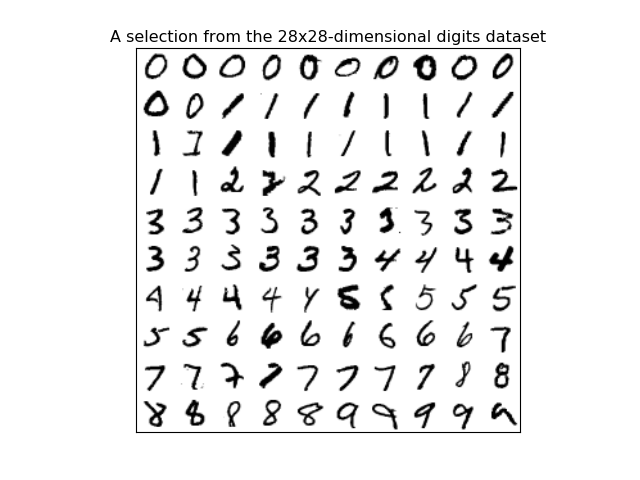

In [45]:
#----------------------------------------------------------------------
# Plot images of the digits
plt.figure()
n_img_per_row = 10
img = np.zeros((30 * n_img_per_row, 30 * n_img_per_row))
for i in range(n_img_per_row):
    ix = 30 * i + 1
    for j in range(n_img_per_row):
        iy = 30 * j + 1
        img[ix:ix + 28, iy:iy + 28] = X[i * n_img_per_row + j].reshape((28, 28))

plt.imshow(img, cmap=plt.cm.binary)
plt.xticks([])
plt.yticks([])
plt.title('A selection from the 28x28-dimensional digits dataset')

<IPython.core.display.Javascript object>


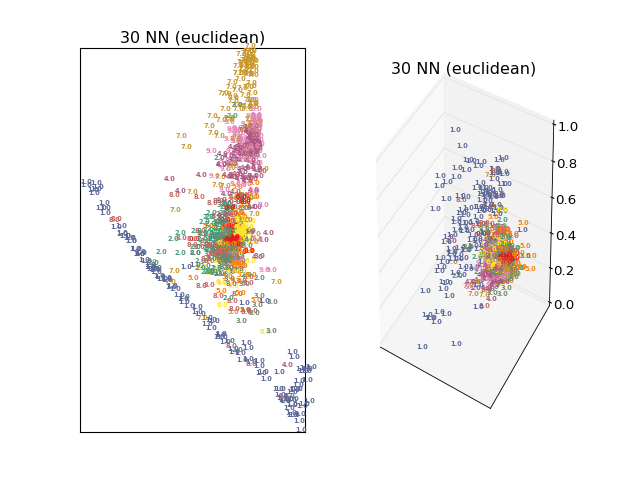

Computing LLE embedding
Done. Reconstruction error: 0.00370226
manhattan
Xind shape:  (999, 10, 784)
ind shape:  (999, 10)
euclidean
Xind shape:  (999, 10, 784)
ind shape:  (999, 10)
euclidean
Xind shape:  (999, 30, 784)
ind shape:  (999, 30)
(999, 2)


In [31]:
#----------------------------------------------------------------------
# Locally linear embedding of the digits dataset
plt.figure()
print("Computing LLE embedding")
clf = manifold.LocallyLinearEmbedding(30, n_components=5,
                                      method='standard')
t0 = time()
X_lle1 = clf.fit_transform(X)
print("Done. Reconstruction error: %g" % clf.reconstruction_error_)

X_lle_302D, M, er30 = lle(X, 10, 2, 'manhattan')
X_lle_302D1, M, er30 = lle(X, 10, 2)
X_lle_303D, M, er30 = lle(X, 30, 3)

plot_2D_embedding(X_lle_302D,
               "30 NN (euclidean)", 121)

plot_3D_embedding(X_lle_303D,
              "30 NN (euclidean)", 122)
#plot_2D_embedding(X_lle_302D1,
#               "30 NN (euclidean)", 122)


<IPython.core.display.Javascript object>


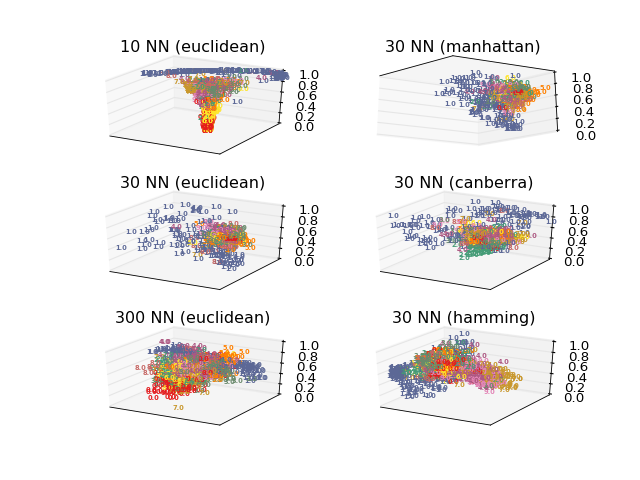

Computing 3D LLE embedding
euclidean
Xind shape:  (1000, 10, 784)
ind shape:  (1000, 10)
0.00085242805804
manhattan
Xind shape:  (1000, 30, 784)
ind shape:  (1000, 30)
hamming
Xind shape:  (1000, 30, 784)
ind shape:  (1000, 30)
canberra
Xind shape:  (1000, 30, 784)
ind shape:  (1000, 30)
euclidean
Xind shape:  (1000, 30, 784)
ind shape:  (1000, 30)
euclidean
Xind shape:  (1000, 300, 784)
ind shape:  (1000, 300)


In [355]:
#----------------------------------------------------------------------
# Locally linear embedding of the digits dataset
plt.figure()
print("Computing 3D LLE embedding")
t0 = time()

X_lle_10, M, er10 = lle(X, 10, 3)
print(er10)
X_lle_30_manhattan, M, er10l1 = lle(X, 30, 3, 'manhattan')
X_lle_30_hamming, M, er10l1 = lle(X, 30, 3, 'hamming')
X_lle_30_canberra, M, er10l1 = lle(X, 30, 3, 'canberra')

X_lle_30, M, er30 = lle(X, 30, 3)
X_lle_300, M, er300 = lle(X, 300, 3)

plot_3D_embedding(X_lle_10,
               "10 NN (euclidean)", 321)
plot_3D_embedding(X_lle_30_manhattan,
               "30 NN (manhattan)", 322)
plot_3D_embedding(X_lle_30,
               "30 NN (euclidean)", 323)
plot_3D_embedding(X_lle_30_canberra,
               "30 NN (canberra)", 324)
plot_3D_embedding(X_lle_300,
               "300 NN (euclidean)", 325)
plot_3D_embedding(X_lle_30_hamming,
               "30 NN (hamming)", 326)


In [ ]:
# reconstruction error
NN = list(range[5,300,5])


<IPython.core.display.Javascript object>


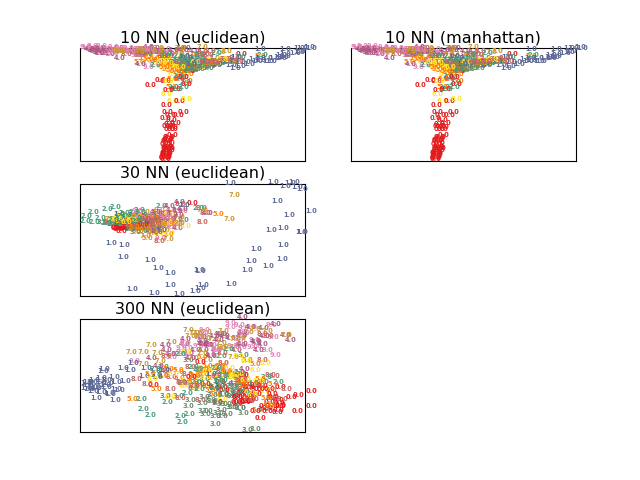

Computing 2D LLE embedding
euclidean
0.12323614076
hamming
euclidean
0.660424400078
euclidean
271.521586967
(400, 10)
(400, 10)
(400, 30)
(400, 300)


In [20]:
#----------------------------------------------------------------------
# Locally linear embedding of the digits dataset
plt.figure()
print("Computing 2D LLE embedding")
t0 = time()

X_lle_10, M, er10 = LLE(X, 10, 2)
print(er10)
X_lle_10_L1, M, er10l1 = LLE(X, 10, 2, 'hamming')
X_lle_30, M, er30 = LLE(X, 30, 2)
print(er30)
X_lle_300, M, er300 = LLE(X, 300, 2)
print(er300)
# print("Done. Reconstruction error: %g" % clf.reconstruction_error_)
plot_2D_embedding(X_lle_10,
               "10 NN (euclidean)", 321)
plot_2D_embedding(X_lle_10_L1,
               "10 NN (manhattan)", 322)
plot_2D_embedding(X_lle_30,
               "30 NN (euclidean)", 323)
plot_2D_embedding(X_lle_300,
               "300 NN (euclidean)", 325)

<IPython.core.display.Javascript object>


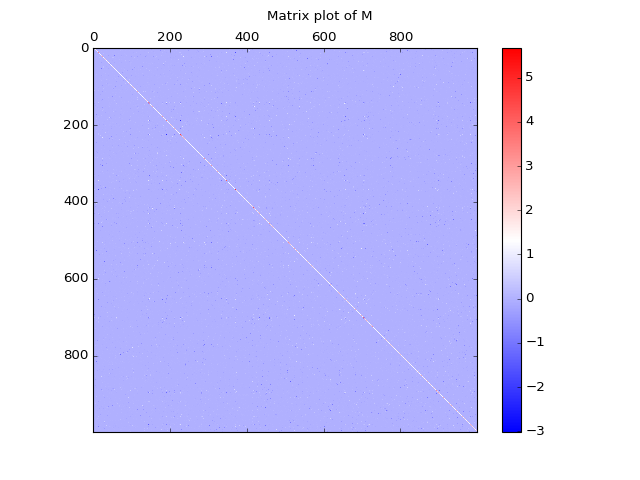

(999,)


<IPython.core.display.Javascript object>


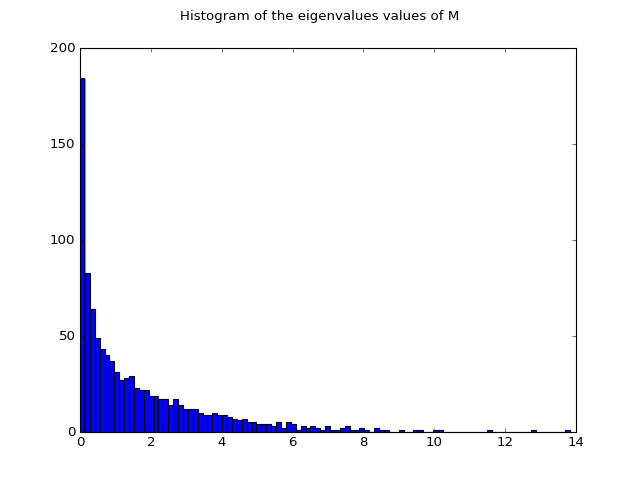

<IPython.core.display.Javascript object>


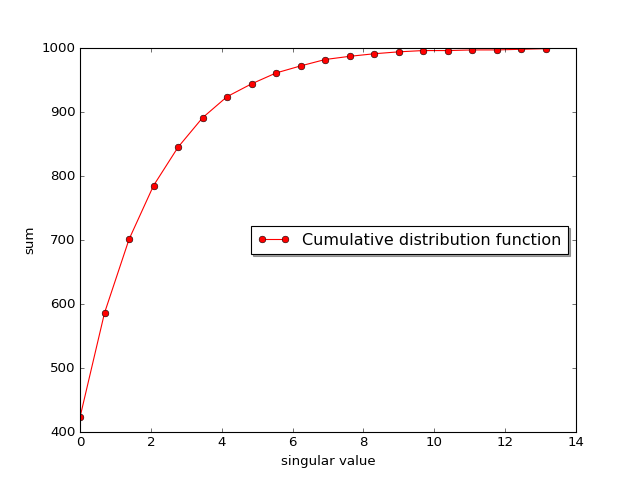

1675.8525087


In [49]:
data = M#X_lle1[:100,:]#np.random.random((4,4))
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(data, interpolation='nearest', cmap=cm.bwr)
fig.colorbar(cax)
fig.suptitle('Matrix plot of M')

U, s, V = np.linalg.svd(M, full_matrices=True)
print(s.shape)


fig = plt.figure()
_ = plt.hist(s, bins=100)
fig.suptitle('Histogram of the eigenvalues values of M')



data = s
fig, ax = plt.subplots()
counts, bins = np.histogram(s, bins=20, density=False)

#bin_centers = np.mean(zip(bins[:-1], bins[1:]), axis=1)
ax.plot(bins[:-1], counts.cumsum(), 'ro-', label='Cumulative distribution function')
legend = ax.legend(loc='center right', shadow=True)
plt.xlabel('singular value')
plt.ylabel('sum')
print(np.sum(s))

euclidean
Xind shape:  (1000, 10, 784)
ind shape:  (1000, 10)


<IPython.core.display.Javascript object>


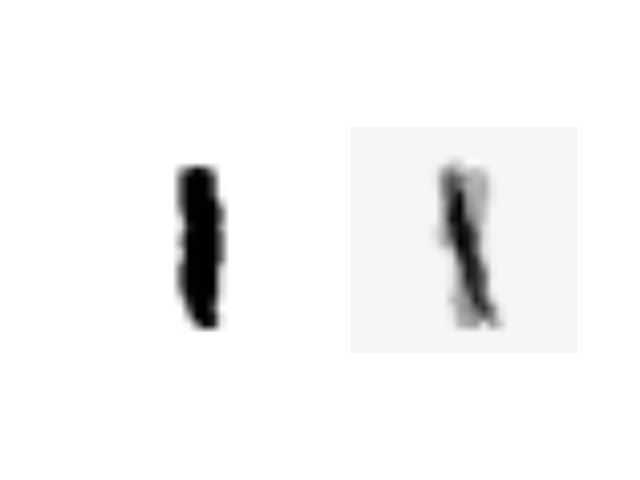

[[-0.00273576  0.00610312]
 [-0.00917814  0.00698546]
 [-0.00170058 -0.04549374]
 ..., 
 [-0.00158234  0.00411551]
 [-0.10199414  0.02465046]
 [ 0.00402769  0.01443064]]


/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


(-0.5, 27.5, 27.5, -0.5)

In [10]:
k = 10
X_lle_30, M, er30 = lle(X, k, 2)

def reconstruct(y, Y, k=10):
    print(Y)
    knn = NearestNeighbors(n_neighbors=k + 1).fit(Y)
    indices = knn.kneighbors(y, return_distance=False)[:,1:].flatten() # Remove sample itself from neighbors

    ns = Y[indices]
    deltas = ns - y
    deltas = deltas.reshape(k, y.shape[0])
    C = np.dot(deltas, np.transpose(deltas))
    factor = np.trace(C) / (k * 1000.0)
    C = C + factor * np.eye(k)
    w = np.linalg.solve(C, np.ones(k))
    w = w / w.sum()
    
    x = np.dot(np.transpose(X[indices].reshape((k,-1))), w)
    img = x.reshape(28,28)
    return img

plt.figure()
plt.subplot(121)
plt.imshow(X[3].reshape(28,28), cmap=plt.cm.binary)
plt.axis('off')

X0_re = reconstruct(X_lle_30[3], X_lle_30)
plt.subplot(122)
plt.imshow(X0_re.reshape(28,28), cmap=plt.cm.binary)
plt.axis('off')

<IPython.core.display.Javascript object>


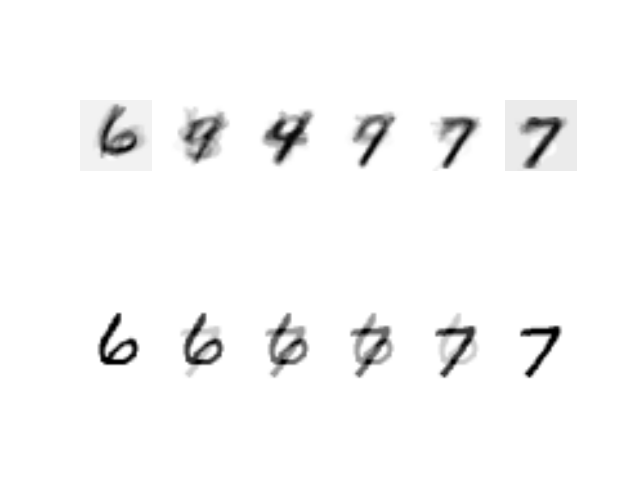

(2,)
[[-0.00273576  0.00610312]
 [-0.00917814  0.00698546]
 [-0.00170058 -0.04549374]
 ..., 
 [-0.00158234  0.00411551]
 [-0.10199414  0.02465046]
 [ 0.00402769  0.01443064]]
(2,)
[[-0.00273576  0.00610312]
 [-0.00917814  0.00698546]
 [-0.00170058 -0.04549374]
 ..., 
 [-0.00158234  0.00411551]
 [-0.10199414  0.02465046]
 [ 0.00402769  0.01443064]]


/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


(2,)
[[-0.00273576  0.00610312]
 [-0.00917814  0.00698546]
 [-0.00170058 -0.04549374]
 ..., 
 [-0.00158234  0.00411551]
 [-0.10199414  0.02465046]
 [ 0.00402769  0.01443064]]
(2,)
[[-0.00273576  0.00610312]
 [-0.00917814  0.00698546]
 [-0.00170058 -0.04549374]
 ..., 
 [-0.00158234  0.00411551]
 [-0.10199414  0.02465046]
 [ 0.00402769  0.01443064]]


/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


(2,)
[[-0.00273576  0.00610312]
 [-0.00917814  0.00698546]
 [-0.00170058 -0.04549374]
 ..., 
 [-0.00158234  0.00411551]
 [-0.10199414  0.02465046]
 [ 0.00402769  0.01443064]]
(2,)
[[-0.00273576  0.00610312]
 [-0.00917814  0.00698546]
 [-0.00170058 -0.04549374]
 ..., 
 [-0.00158234  0.00411551]
 [-0.10199414  0.02465046]
 [ 0.00402769  0.01443064]]


/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


In [13]:
#X_lle_30, M, er30 = lle(X, k, 2)
z1 = X[2]
z2 = X[9]

y1 = X_lle_30[2]
y2 = X_lle_30[9]
xx = np.linspace(0, 1, 6)
plt.figure()
for j, i in enumerate(xx):
    z = i * y1 + (1-i)*y2
    print(z.shape)
    yl = reconstruct(z, X_lle_30)
    plt.subplot(2,6,j+1)
    plt.imshow(yl.reshape(28,28), cmap=plt.cm.binary)
    plt.axis('off')
    
    plt.subplot(2,6,j+1+6)
    z = i * z1 + (1-i)*z2
    plt.imshow(z.reshape(28,28), cmap=plt.cm.binary)
    plt.axis('off')
    